In [133]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
data = pd.read_csv("avail_data.csv", parse_dates=['측정시간'], encoding='cp949').sort_values('측정시간').reset_index(drop=True)
data

,측정시간,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,total_num,cum_num,cum_rate
0,2024-04-01 00:20:00,onlie,48.666667,31.333333,-2.333333,38.666667,YSHS0079,1,1,1.000000
1,2024-04-01 00:20:00,onlie,44.000000,25.000000,0.000000,37.500000,YSHSHFC0008,1,1,1.000000
2,2024-04-01 00:20:00,onlie,40.500000,31.000000,7.000000,42.500000,YSWS0154,1,1,1.000000
3,2024-04-01 00:20:00,onlie,43.000000,30.400000,-0.200000,36.200000,YSYW0063B,1,1,1.000000
4,2024-04-01 00:20:00,onlie,43.000000,35.000000,-1.000000,40.000000,YSHS0035,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
95740,2024-05-01 23:00:00,onlie,32.000000,27.000000,-10.000000,39.500000,YSJSC2004,2405,1380,0.573805
95741,2024-05-01 23:00:00,onlie,35.000000,32.000000,13.000000,38.000000,YSHS0013,1329,341,0.256584
95742,2024-05-01 23:00:00,onlie,50.000000,31.000000,-3.000000,37.000000,YSSB2-7,1434,341,0.237796
95743,2024-05-01 23:00:00,onlie,43.750000,20.500000,5.250000,42.500000,YSWS0217,2177,1084,0.497933


In [134]:
# 데이터 불러오기 2
outlier = pd.read_csv("장애내역_수정.csv", encoding='cp949').drop_duplicates().reset_index(drop=True)

# 장애내역 데이터의 측정시간은 settop과 다르게 뒤에 +09:00가 붙어있음 -> 삭제
outlier['측정시간'] = outlier['측정시간'].str.replace("+09:00", "")

# 측정시간 열 날짜형식으로 변경
outlier['측정시간'] = pd.to_datetime(outlier['측정시간'])
outlier = outlier.drop(columns = ['index'])
outlier

,셀번호,측정시간,장애여부
0,YSWS4-5,2024-04-01 10:34:43,MAJOR
1,YSSB1-6,2024-04-01 11:13:33,MAJOR
2,YSWS0244,2024-04-01 15:22:45,CRITICAL
3,YSWSG3-4B,2024-04-02 10:54:25,MAJOR
4,YSJB5-25,2024-04-02 13:41:30,MAJOR
...,...,...,...
181,YSYW0030,2024-04-30 09:33:27,MAJOR
182,YSYW0030,2024-04-30 10:01:47,CRITICAL
183,YSWS8-5,2024-04-30 14:31:26,MAJOR
184,YSYW0009,2024-04-30 14:44:35,MAJOR


In [135]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 장애내역 데이터는 시간단위가 초 단위로 측정이 되었지만 settop 데이터는 5분단위임 따라서 settop데이터에서 가장 가까운 앞쪽 시간을 찾아 장애 발생지점으로 선정

def find_nearest_time(df, target_time, cell_number):

    # 해당 셀번호가 df안에 존재하는 경우
    if cell_number in df['셀번호'].unique():

        # 장애발생 시간보다 나중 시간인 데이터 제외
        temp_df = df[df['측정시간'] <= target_time]

        # 그 중 셀번호가 동일한 경우만 남김
        temp_df = temp_df[temp_df['셀번호'] == cell_number]
        
        # 조건에 맞는 행이 존재하는 경우 즉 행의 개수가 0이 아닌 경우
        if len(temp_df) != 0:
            # 가장 가까운 시간을 가져와야함 이 때 df는 측정시간 기준 정렬이 되어 있으므로 가장 마지막 행을 가져옴
            return temp_df.iloc[-1]

merged = []

# 장애 발생 df에 대하여 모든 행에 수행
for _, row in outlier.iterrows():
    nearest_row = find_nearest_time(data, row['측정시간'], row['셀번호'])

    if nearest_row is not None:

        # 장애여부 열을 생성하여 1 지정
        nearest_row['장애여부'] = 1

        # 조건에 부합하는 행 merged에 저장
        merged.append(nearest_row)

# merged 리스트에 저장된 데이터 df 화
merged_df = pd.DataFrame(merged)
merged_df = merged_df.drop_duplicates()
merged_df

,측정시간,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,total_num,cum_num,cum_rate,장애여부
785,2024-04-01 09:00:00,onlie,42.000000,30.000000,-4.000000,39.000000,YSWS4-5,4,0,0.000000,1
1018,2024-04-01 10:10:00,onlie,33.000000,31.000000,-6.000000,35.000000,YSSB1-6,5,0,0.000000,1
4371,2024-04-02 10:50:00,onlie,35.000000,33.000000,6.000000,42.000000,YSWSG3-4B,40,29,0.725000,1
4335,2024-04-02 10:30:00,onlie,30.000000,34.000000,-13.000000,34.500000,YSJB5-25,51,26,0.509804,1
7631,2024-04-03 08:50:00,onlie,40.000000,30.000000,9.000000,42.000000,YSJSC2003,88,14,0.159091,1
...,...,...,...,...,...,...,...,...,...,...,...
91742,2024-04-30 09:00:00,onlie,54.000000,26.000000,16.000000,41.000000,YSYW0030,795,260,0.327044,1
91843,2024-04-30 10:00:00,onlie,55.000000,30.000000,0.000000,39.000000,YSYW0030,798,260,0.325815,1
85052,2024-04-27 21:45:00,onlie,48.000000,31.000000,-4.000000,39.000000,YSWS8-5,20,0,0.000000,1
92329,2024-04-30 14:35:00,onlie,42.888889,29.000000,-2.888889,36.666667,YSYW0009,2310,1133,0.490476,1


In [136]:
# 장애발생을 1 , 정상을 0으로 지정
data['장애여부'] = 0

# merged_df에 존재하는 데이터는 장애 발생 데이터 이므로 이와 동일한 인덱스를 가진 data에는 장애여부를 1로 설정
# merged_df는 data에서 가져온 행이기 때문에 인덱스가 동일함
data['장애여부'].loc[merged_df.index] = 1

In [137]:
# 측정시간 열을 일, 시, 분, 요일로 나눔 이 때 연도는 차이가 없기 때문에 컬럼에 따로 넣지 않음
# 5월 데이터가 있지만, 5월 1일만 존재하여 month 추가 하지 않음

data['일'] = data['측정시간'].dt.day
data['시'] = data['측정시간'].dt.hour
data['분'] = data['측정시간'].dt.minute
data['요일'] = data['측정시간'].dt.weekday
data = data.drop(columns=['측정시간'])
data

,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,total_num,cum_num,cum_rate,장애여부,일,시,분,요일
0,onlie,48.666667,31.333333,-2.333333,38.666667,YSHS0079,1,1,1.000000,0,1,0,20,0
1,onlie,44.000000,25.000000,0.000000,37.500000,YSHSHFC0008,1,1,1.000000,0,1,0,20,0
2,onlie,40.500000,31.000000,7.000000,42.500000,YSWS0154,1,1,1.000000,0,1,0,20,0
3,onlie,43.000000,30.400000,-0.200000,36.200000,YSYW0063B,1,1,1.000000,0,1,0,20,0
4,onlie,43.000000,35.000000,-1.000000,40.000000,YSHS0035,1,0,0.000000,0,1,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95740,onlie,32.000000,27.000000,-10.000000,39.500000,YSJSC2004,2405,1380,0.573805,0,1,23,0,2
95741,onlie,35.000000,32.000000,13.000000,38.000000,YSHS0013,1329,341,0.256584,0,1,23,0,2
95742,onlie,50.000000,31.000000,-3.000000,37.000000,YSSB2-7,1434,341,0.237796,0,1,23,0,2
95743,onlie,43.750000,20.500000,5.250000,42.500000,YSWS0217,2177,1084,0.497933,0,1,23,0,2


### 온오프라인여부, 셀번호 미상용으로 인한 주석처리 ###
미사용 이유

1. 온오프라인
<br>기존 온오프라인 사용여부 열의 여러 값들(w-online 등등)을 모두 online으로 봐도 무방하다는 가이드라인이 존재했음
<br>전처리 시 on/off 이분화를 진행함
<br>하지만 명칭이 다르기 때문에 100% 일치하지는 않는 값임
<br>피쳐 포함, 미포함 분석을 해보았는데 결과는 비슷하게 나와 분석에서 제외하기로 결정

2. 셀번호
<br>장애가 있는 셋탑박스의 데이터만 사용하여 모델을 학습
<br>하지만 실제 장애 예측은 전체 셋탑박스에 대해 이루어져야 함 즉, 모델이 장애가 있는 셋탑박스뿐만 아니라 장애가 없는 셋탑박스도 예측할 수 있어야 함
<br>셀번호를 모델 학습에 포함시키면 오류가 발생할 수 있음
<br>또한 셀번호는 각 셋탑박스를 구분하는 고유 식별자이므로, 특정 셋탑박스에 대한 학습 데이터가 모델에 과도하게 맞춰지는(과적합) 현상을 일으킬 수 있음
<br>마찬가지로 피쳐 포함, 미포함 분석을 해보았는데 결과는 비슷하게 나와 분석에서 제외하기로 결정

In [138]:
# from sklearn.preprocessing import LabelEncoder
# # labelencoder를 통해 문자형 변수 온오프라인여부 int로 치환

# le1 = LabelEncoder()
# le2 = LabelEncoder()

# data['온오프라인여부'] = le1.fit_transform(data['온오프라인여부'])
# data['셀번호'] = le2.fit_transform(data['셀번호'])

# cum_rate만 사용하기 때문에 total_num과 cum_num 삭제
data = data.drop(columns=['total_num'])
data = data.drop(columns=['cum_num'])
data = data.drop(columns=['온오프라인여부'])

data

,상향파워2,상향SNR,하향파워,하향SNR,셀번호,cum_rate,장애여부,일,시,분,요일
0,48.666667,31.333333,-2.333333,38.666667,YSHS0079,1.000000,0,1,0,20,0
1,44.000000,25.000000,0.000000,37.500000,YSHSHFC0008,1.000000,0,1,0,20,0
2,40.500000,31.000000,7.000000,42.500000,YSWS0154,1.000000,0,1,0,20,0
3,43.000000,30.400000,-0.200000,36.200000,YSYW0063B,1.000000,0,1,0,20,0
4,43.000000,35.000000,-1.000000,40.000000,YSHS0035,0.000000,0,1,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...
95740,32.000000,27.000000,-10.000000,39.500000,YSJSC2004,0.573805,0,1,23,0,2
95741,35.000000,32.000000,13.000000,38.000000,YSHS0013,0.256584,0,1,23,0,2
95742,50.000000,31.000000,-3.000000,37.000000,YSSB2-7,0.237796,0,1,23,0,2
95743,43.750000,20.500000,5.250000,42.500000,YSWS0217,0.497933,0,1,23,0,2


In [139]:
# 특정 시간기준 이전 시점의 데이터와 비교하는 lag 추가
# t시점 데이터에서 lag가 1인 경우 t-1 시점의 데이터
def add_lag_features(df, group_col, target_cols, lag_num):
    temp_df = df.copy()

    # 원하는 열에 대해 모두 수행하기 위해 반복문 추가
    for col in target_cols:
        # 원하는 lag의 수 만큼 수행하기 위해 반복문 추가
        for lag in range(1, lag_num + 1):
            # 원하는 열의 기준값에서 lag만큼 이동한 lag 피쳐 생성하고 df에 추가
            temp_df[f'{col}_lag{lag}'] = temp_df.groupby(group_col)[col].shift(lag)
    return temp_df

target_cols = ['상향파워2', '상향SNR', '하향파워', '하향SNR']

lag_num=5

data_with_lags = add_lag_features(data, '셀번호', target_cols, lag_num)

data_with_lags = data_with_lags.dropna().reset_index(drop=True)
data_with_lags

,상향파워2,상향SNR,하향파워,하향SNR,셀번호,cum_rate,장애여부,일,시,분,...,하향파워_lag1,하향파워_lag2,하향파워_lag3,하향파워_lag4,하향파워_lag5,하향SNR_lag1,하향SNR_lag2,하향SNR_lag3,하향SNR_lag4,하향SNR_lag5
0,43.500000,30.500000,5.500000,42.000000,YSWS0217,0.500000,0,1,1,30,...,10.000000,10.000000,13.000000,-3.000000,0.666667,41.000000,41.000000,45.000000,41.000000,42.333333
1,43.000000,35.000000,2.000000,32.000000,YSJBG6-1F,0.666667,0,1,1,30,...,2.333333,1.000000,2.333333,-2.000000,-1.250000,35.333333,39.000000,34.333333,34.000000,36.000000
2,53.000000,39.000000,-6.000000,32.000000,YSJSC4007,0.333333,0,1,1,30,...,-6.000000,3.000000,2.000000,-3.000000,-3.000000,31.000000,38.000000,38.000000,35.500000,35.500000
3,41.454545,28.818182,-0.272727,37.181818,YSDGHFC0054,1.000000,0,1,1,30,...,-1.400000,-1.846154,-2.466667,-2.000000,-1.727273,36.866667,36.615385,36.200000,36.700000,36.636364
4,46.000000,29.333333,-8.000000,33.666667,YSHS0065,1.000000,0,1,1,30,...,2.000000,-4.333333,-1.000000,0.666667,1.200000,34.500000,34.000000,34.833333,35.333333,34.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95248,32.000000,27.000000,-10.000000,39.500000,YSJSC2004,0.573805,0,1,23,0,...,-3.000000,1.000000,6.000000,6.000000,1.000000,38.000000,39.909091,41.000000,40.000000,41.000000
95249,35.000000,32.000000,13.000000,38.000000,YSHS0013,0.256584,0,1,23,0,...,9.500000,13.000000,12.000000,12.000000,12.000000,37.000000,38.000000,38.000000,38.000000,38.000000
95250,50.000000,31.000000,-3.000000,37.000000,YSSB2-7,0.237796,0,1,23,0,...,-1.000000,-2.000000,-1.000000,0.000000,-12.000000,35.000000,34.000000,35.000000,35.000000,36.000000
95251,43.750000,20.500000,5.250000,42.500000,YSWS0217,0.497933,0,1,23,0,...,8.000000,7.000000,2.000000,1.000000,6.000000,43.000000,43.000000,43.000000,42.000000,43.000000


In [140]:
# 셀번호는 모델 학습에 사용하지 않기 때문에 삭제해줌
data_with_lags = data_with_lags.drop(columns=['셀번호'])

In [141]:
data_with_lags

,상향파워2,상향SNR,하향파워,하향SNR,cum_rate,장애여부,일,시,분,요일,...,하향파워_lag1,하향파워_lag2,하향파워_lag3,하향파워_lag4,하향파워_lag5,하향SNR_lag1,하향SNR_lag2,하향SNR_lag3,하향SNR_lag4,하향SNR_lag5
0,43.500000,30.500000,5.500000,42.000000,0.500000,0,1,1,30,0,...,10.000000,10.000000,13.000000,-3.000000,0.666667,41.000000,41.000000,45.000000,41.000000,42.333333
1,43.000000,35.000000,2.000000,32.000000,0.666667,0,1,1,30,0,...,2.333333,1.000000,2.333333,-2.000000,-1.250000,35.333333,39.000000,34.333333,34.000000,36.000000
2,53.000000,39.000000,-6.000000,32.000000,0.333333,0,1,1,30,0,...,-6.000000,3.000000,2.000000,-3.000000,-3.000000,31.000000,38.000000,38.000000,35.500000,35.500000
3,41.454545,28.818182,-0.272727,37.181818,1.000000,0,1,1,30,0,...,-1.400000,-1.846154,-2.466667,-2.000000,-1.727273,36.866667,36.615385,36.200000,36.700000,36.636364
4,46.000000,29.333333,-8.000000,33.666667,1.000000,0,1,1,30,0,...,2.000000,-4.333333,-1.000000,0.666667,1.200000,34.500000,34.000000,34.833333,35.333333,34.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95248,32.000000,27.000000,-10.000000,39.500000,0.573805,0,1,23,0,2,...,-3.000000,1.000000,6.000000,6.000000,1.000000,38.000000,39.909091,41.000000,40.000000,41.000000
95249,35.000000,32.000000,13.000000,38.000000,0.256584,0,1,23,0,2,...,9.500000,13.000000,12.000000,12.000000,12.000000,37.000000,38.000000,38.000000,38.000000,38.000000
95250,50.000000,31.000000,-3.000000,37.000000,0.237796,0,1,23,0,2,...,-1.000000,-2.000000,-1.000000,0.000000,-12.000000,35.000000,34.000000,35.000000,35.000000,36.000000
95251,43.750000,20.500000,5.250000,42.500000,0.497933,0,1,23,0,2,...,8.000000,7.000000,2.000000,1.000000,6.000000,43.000000,43.000000,43.000000,42.000000,43.000000


### 모델 리스트 ###
1. XGBoost
2. LogisticRegression
3. SupportVectorMachine
4. RandomForest
5. Catboost

- 보통의 경우 f1 score를 통해 모델 평가를 진행 함
    - 하지만 데이터가 한쪽으로 치우쳐 있는 경우 f1 score는 좋은 방법이 아님
    - ex 100개의 데이터 중 비정상이 5개가 존재함 이 때 학습된 모델이 모두 정상이라고 예측하면 정확도는 95%가 되고 f1 score는 좋게 나옴

- 따라서 settop 데이터의 경우 장애 데이터가 현저히 적기 때문에 ROC 곡선을 통해 평가 진행
    - ROC 곡선은 정상 비정상을 구분하는 임계값을 변화시키면서 얻을 수 있는 precision과 recall값의 변화를 시각적으로 보여 줌
    - 또한 AUC(Area Under Curve)를 통해 이를 하나의 숫자로 요악하여 비교 가능


📌 모델만 변경하고 동일한 코드를 사용했기 때문에 첫 번째를 제외한 코드 주석 생략

100%|██████████| 199/199 [00:01<00:00, 142.36it/s]


Best Threshold: 0.064
Best F1 Score: 0.1081
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19025
           1       0.18      0.08      0.11        26

    accuracy                           1.00     19051
   macro avg       0.59      0.54      0.55     19051
weighted avg       1.00      1.00      1.00     19051



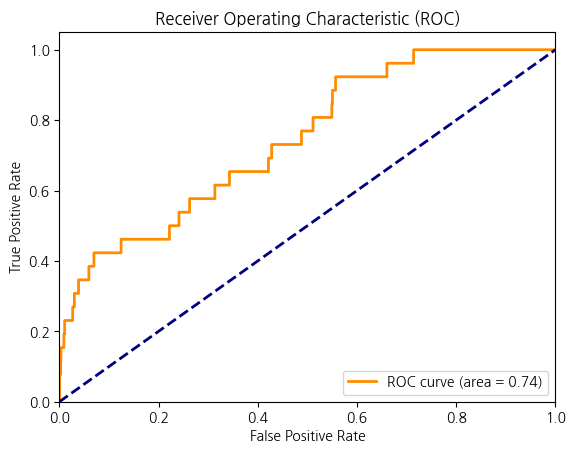

[[19016     9]
 [   24     2]]


In [142]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm.auto import tqdm

# 장애여부를 제외한 모든 열을 X, 장애여부를 y로 지정
X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

# train 0.8, test 0.2로 구분
# 장애 발생 데이터가 정상 데이터보다 훨씬 적기 때문에 stratify를 설정하여 학습데이터와 테스트데이터에 대해 장애 발생 데이터 비율을 맞춰줌
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)


model = XGBClassifier(learning_rate=0.1, n_estimators=1000)

# early stopping을 사용하여 과적합 방지
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

# 모델을 저장
model.save_model("xgb_model.json")

# 최적의 임계값과 f1 score를 찾기
best_threshold = 0
best_f1_score = 0

# 테스트 데이터에 대한 예측 확률 계산
y_proba = model.predict_proba(X_test)[:, 1]

# 0.2 ~ 0.001까지 반복문을 통해 f1 score를 계산
for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    
    # 예측 확률이 임계값보다 큰 경우 True, 작은 경우 False
    y_pred = y_proba > threshold

    # 실제 값과 예측 값 f1 score 계산
    f1 = f1_score(y_test, y_pred)
    
    # 현재 f1 score가 이전 까지의 f1 score 중 가장 best인 값보다 큰 경우 업데이트
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

# 최적의 임계값을 사용하여 최종 예측 수행
y_pred = y_proba > best_threshold

# 모델 성능 평가지표 출력
print(classification_report(y_test, y_pred))

# ROC 곡선과 AUC 계산 및 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# confusion_matrix 출력
print(confusion_matrix(y_test, y_pred))

In [143]:
# test 데이터에 고장 확률과 실제 장애 여부 열을 추가하여 비교
X_test['고장확률'] = y_proba
X_test['실제장애여부'] = y_test

# 고장확률이 높은 순서대로 정렬하여 실제 장애여부와 비교
X_test.sort_values('고장확률', ascending=False)[:50]

,상향파워2,상향SNR,하향파워,하향SNR,cum_rate,일,시,분,요일,상향파워2_lag1,...,하향파워_lag3,하향파워_lag4,하향파워_lag5,하향SNR_lag1,하향SNR_lag2,하향SNR_lag3,하향SNR_lag4,하향SNR_lag5,고장확률,실제장애여부
58425,37.500000,28.750000,5.500000,43.000000,0.079268,18,2,5,3,36.000000,...,3.000000,2.000000,2.000000,34.000000,37.000000,36.000000,37.000000,37.000000,0.187906,0
52218,49.000000,38.000000,2.000000,38.000000,0.069333,16,1,25,1,49.000000,...,6.000000,2.000000,2.000000,38.000000,40.000000,38.500000,38.000000,38.000000,0.174587,0
59324,40.000000,36.000000,-1.000000,31.000000,0.870157,18,11,25,3,40.000000,...,4.000000,-1.000000,-3.000000,31.000000,35.000000,31.000000,35.000000,35.000000,0.099715,0
72818,35.000000,38.000000,-7.000000,29.000000,0.388521,23,10,20,1,41.142857,...,-2.000000,-2.000000,-2.000000,33.714286,35.000000,34.000000,34.000000,35.000000,0.095892,0
58609,38.000000,36.000000,-3.000000,35.000000,0.000000,18,3,25,3,38.000000,...,-4.000000,-4.000000,-3.000000,34.000000,35.000000,35.000000,34.000000,35.000000,0.089787,0
58157,43.000000,36.000000,-1.000000,35.000000,0.057065,18,0,25,3,43.000000,...,-4.000000,-4.000000,-4.000000,34.000000,34.000000,34.000000,34.000000,34.000000,0.089394,1
73237,36.000000,38.000000,-2.000000,30.000000,0.386413,23,14,0,1,37.666667,...,-4.000000,1.000000,1.000000,33.333333,36.000000,36.000000,37.000000,38.000000,0.069312,0
89417,45.000000,28.000000,0.000000,42.000000,0.117949,29,13,35,0,45.000000,...,4.000000,4.000000,1.000000,42.000000,42.000000,39.000000,39.000000,42.000000,0.065437,0
58451,35.000000,30.000000,1.000000,38.000000,0.096408,18,2,15,3,35.000000,...,-1.000000,-1.000000,-1.000000,38.000000,43.000000,38.000000,38.000000,37.000000,0.064842,1
72843,35.000000,42.000000,-7.000000,29.000000,0.388235,23,10,30,1,35.000000,...,-2.000000,-2.000000,-2.000000,29.000000,33.714286,35.000000,34.000000,34.000000,0.064416,0


100%|██████████| 199/199 [00:01<00:00, 145.66it/s]


Best Threshold: 0.006
Best F1 Score: 0.0100
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19025
           1       0.01      0.08      0.01        26

    accuracy                           0.98     19051
   macro avg       0.50      0.53      0.50     19051
weighted avg       1.00      0.98      0.99     19051



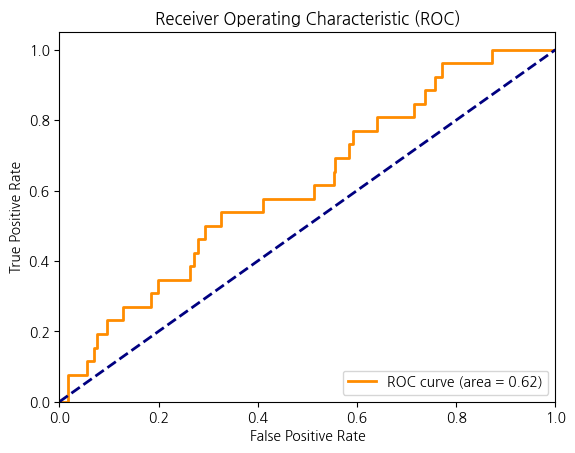

[[18654   371]
 [   24     2]]


In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

best_threshold = 0
best_f1_score = 0
y_proba = model.predict_proba(X_test)[:, 1]

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    y_pred = y_proba > threshold
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

y_pred = y_proba > best_threshold

print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(confusion_matrix(y_test, y_pred))


100%|██████████| 199/199 [00:00<00:00, 223.02it/s]


Best Threshold: 0.000
Best F1 Score: 0.0000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19025
           1       0.00      1.00      0.00        26

    accuracy                           0.00     19051
   macro avg       0.00      0.50      0.00     19051
weighted avg       0.00      0.00      0.00     19051



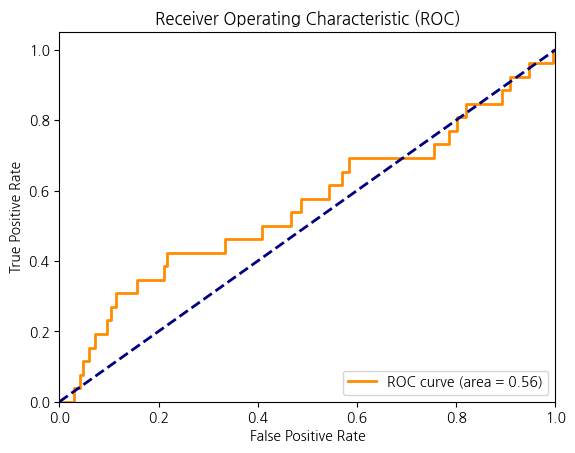

[[    0 19025]
 [    0    26]]


In [145]:
from sklearn.svm import SVC

X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

model = SVC(probability=True)
model.fit(X_train, y_train)

best_threshold = 0
best_f1_score = 0
y_proba = model.predict_proba(X_test)[:, 1]

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    y_pred = y_proba > threshold
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

y_pred = y_proba > best_threshold

print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(confusion_matrix(y_test, y_pred))


100%|██████████| 199/199 [00:00<00:00, 201.06it/s]


Best Threshold: 0.070
Best F1 Score: 0.0339
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19025
           1       0.03      0.04      0.03        26

    accuracy                           1.00     19051
   macro avg       0.51      0.52      0.52     19051
weighted avg       1.00      1.00      1.00     19051



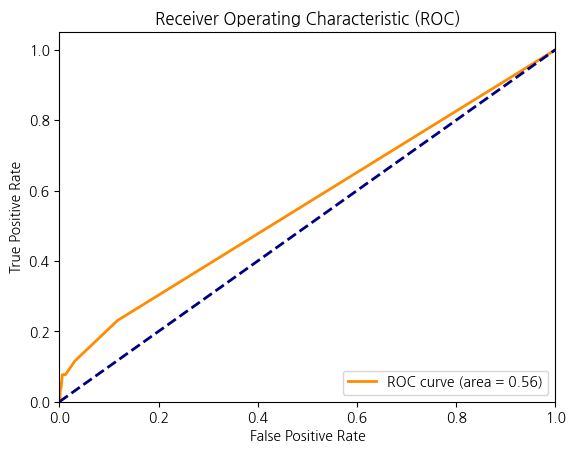

[[18993    32]
 [   25     1]]


In [146]:
from sklearn.ensemble import RandomForestClassifier

X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

best_threshold = 0
best_f1_score = 0
y_proba = model.predict_proba(X_test)[:, 1]

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    y_pred = y_proba > threshold
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

y_pred = y_proba > best_threshold

print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(confusion_matrix(y_test, y_pred))


100%|██████████| 199/199 [00:00<00:00, 212.12it/s]


Best Threshold: 0.033
Best F1 Score: 0.0833
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19025
           1       0.09      0.08      0.08        26

    accuracy                           1.00     19051
   macro avg       0.54      0.54      0.54     19051
weighted avg       1.00      1.00      1.00     19051



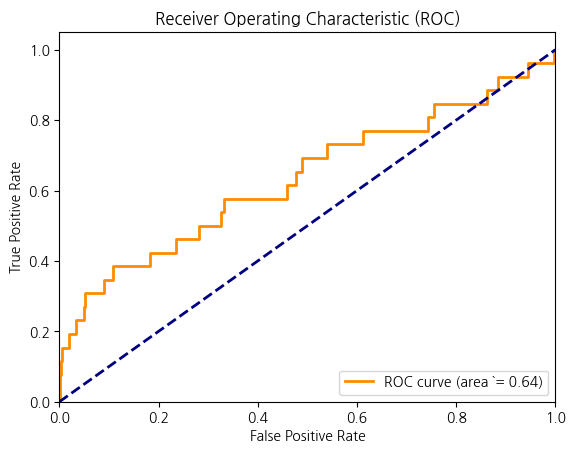

[[19005    20]
 [   24     2]]


In [147]:
from catboost import CatBoostClassifier

X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

model = CatBoostClassifier(learning_rate=0.1, n_estimators=1000, verbose=False)
model.fit(X_train, y_train)

best_threshold = 0
best_f1_score = 0
y_proba = model.predict_proba(X_test)[:, 1]

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    y_pred = y_proba > threshold
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

y_pred = y_proba > best_threshold

print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area `= {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(confusion_matrix(y_test, y_pred))


### feature_importance ###

- 의사결정나무 기반 앙상블 모델에서만 지원하는 값
- XGBoost의 경우 weight, gain, cover 3가지로 지원
    - weight : 해당 feature가 노드 분기에 사용된 횟수
    - gain : 노드가 특정 feature로 분기되었을 대 얻는 성능 상 이득 (기본 값)
    - cover : 해당 feature와 관련된 샘플의 상대적 개수

### shap_value ###

- 게임이론에 기반하여 각 변수의 예측에 대한 기여도를 공정하게 분배하는 방법

       Feature  Importance
5            일   11.701329
6            시   10.045523
4     cum_rate    7.284493
8           요일    6.674687
1        상향SNR    4.670997
7            분    4.384762
21   하향파워_lag3    3.818994
10  상향파워2_lag2    3.186886
22   하향파워_lag4    3.134854
0        상향파워2    3.049794
18  상향SNR_lag5    2.605719
11  상향파워2_lag3    2.593636
17  상향SNR_lag4    2.508852
24  하향SNR_lag1    2.482029
16  상향SNR_lag3    2.478635
14  상향SNR_lag1    2.469691
9   상향파워2_lag1    2.305967
2         하향파워    2.292200
15  상향SNR_lag2    2.231194
13  상향파워2_lag5    2.217715
3        하향SNR    2.209405
25  하향SNR_lag2    2.164612
28  하향SNR_lag5    2.127226
20   하향파워_lag2    2.110494
12  상향파워2_lag4    2.101882
23   하향파워_lag5    2.093243
26  하향SNR_lag3    1.793118
19   하향파워_lag1    1.747324
27  하향SNR_lag4    1.514738


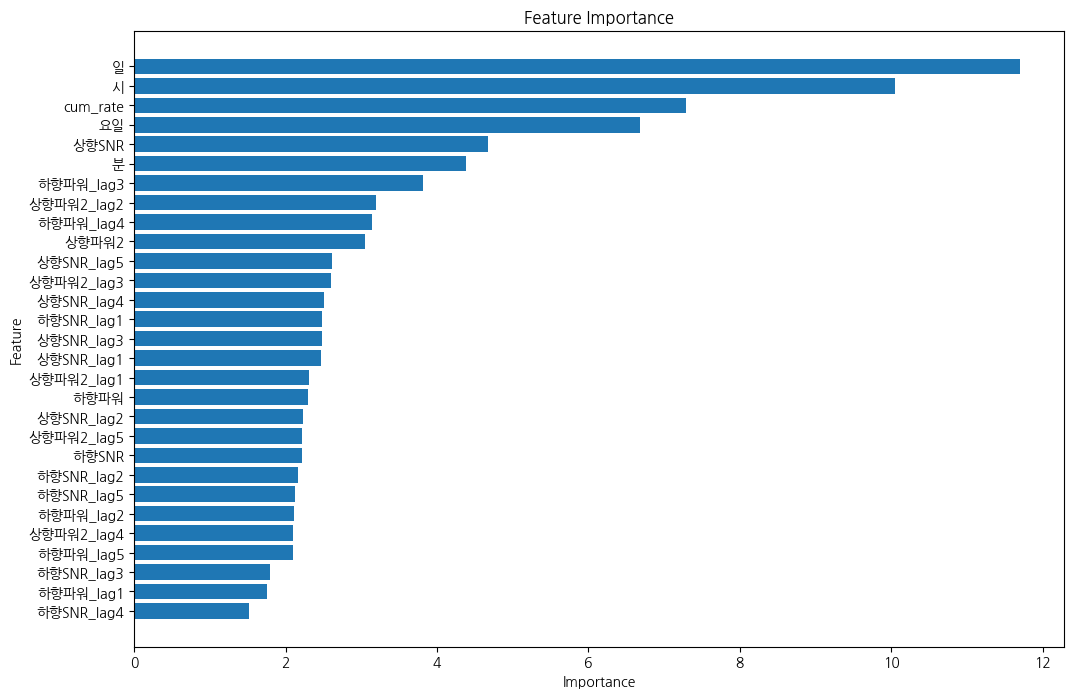

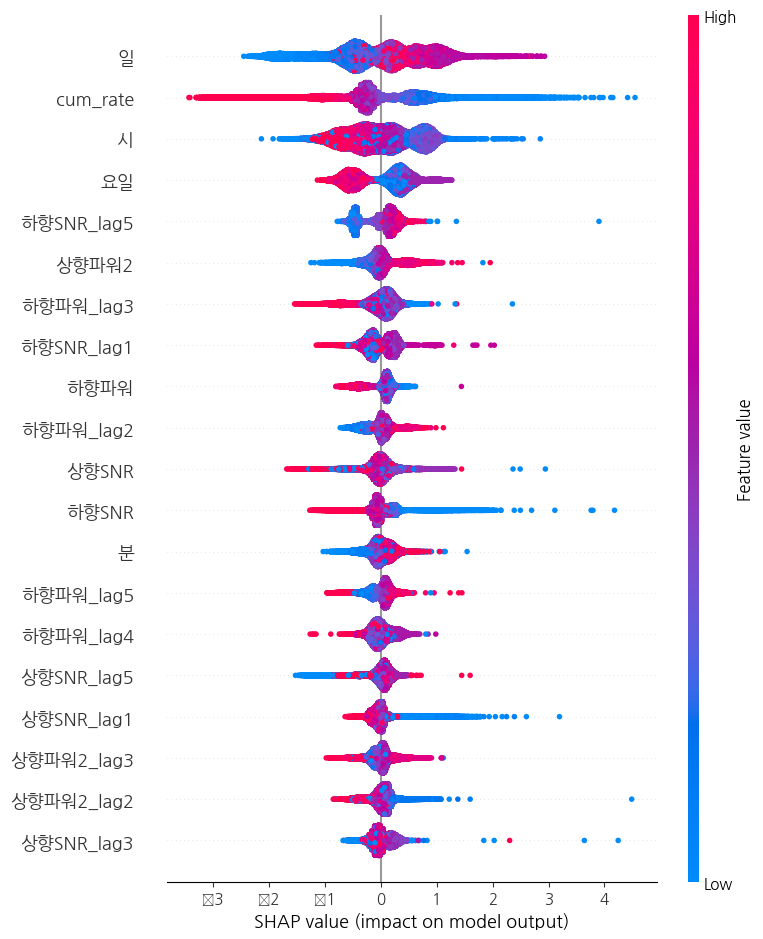

In [148]:
import shap

# 모델 feature_importance 값 저장
feature_importances = model.feature_importances_

# 열 마다 feature_importance 값 df화
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 높은순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# 그래프
plt.figure(figsize=(12, 8))
plt.rc('font', family='NanumGothic')
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# shap_value 값 추출
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 그래프
shap.summary_plot(shap_values, X)

### Out Of Fold 를 통한 모델 학습 ###
- 교차 검증을 통해 모델의 일반화 성능을 정확하게 파악
- 다양한 모델의 장점을 결합하여 앙상블 학습의 최정 예측 성능 향상

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:02<00:00, 66.62it/s]


Best Threshold: 0.018
Best F1 Score: 0.0632
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     95123
           1       0.04      0.16      0.06       130

    accuracy                           0.99     95253
   macro avg       0.52      0.58      0.53     95253
weighted avg       1.00      0.99      1.00     95253



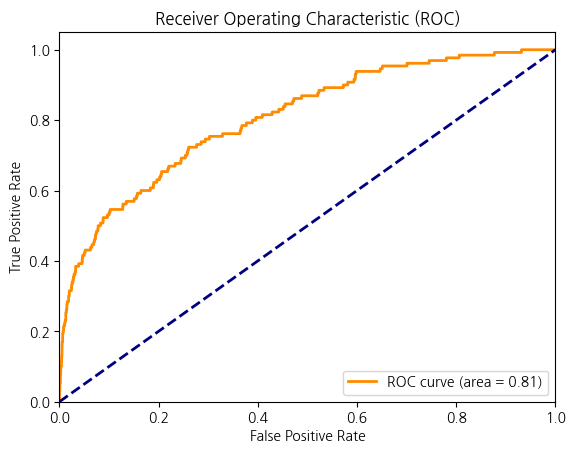

[[94609   514]
 [  109    21]]


In [153]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tqdm.auto import tqdm
from catboost import CatBoostClassifier

X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

# 데이터를 10개의 계층으로 나눔 이 때 StratifiedKFold를 통해 장애, 비장애 비율이 유지되도록 설정
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=30)

# oof를 사용한 예측값을 저장할 변수 설정
oof_preds = np.zeros(X.shape[0])

# train, valid 셋을 oof로 나누어서 분석
for train_idx, valid_idx in tqdm(skf.split(X, y), total=n_splits):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # 모델 학습
    model = XGBClassifier(learning_rate=0.1, n_estimators=1000)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=50)
    
    # 모델을 통해 예측한 valid 값을 off_preds에 저장
    oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]

# 이전과 동일하게 최적의 임계값 찾음
best_threshold = 0
best_f1_score = 0

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    oof_predict = oof_preds > threshold
    f1 = f1_score(y, oof_predict)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

# 임계값 기준 True, False 저장
oof_predict = oof_preds > best_threshold

# 실제 값과 예측값 비교
print(classification_report(y, oof_predict))

# ROC 그래프
fpr, tpr, _ = roc_curve(y, oof_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(confusion_matrix(y, oof_predict))

100%|██████████| 199/199 [00:04<00:00, 46.32it/s]


Best Threshold: 0.200
Best F1 Score: 0.0027
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     95123
           1       0.00      1.00      0.00       130

    accuracy                           0.00     95253
   macro avg       0.00      0.50      0.00     95253
weighted avg       0.00      0.00      0.00     95253



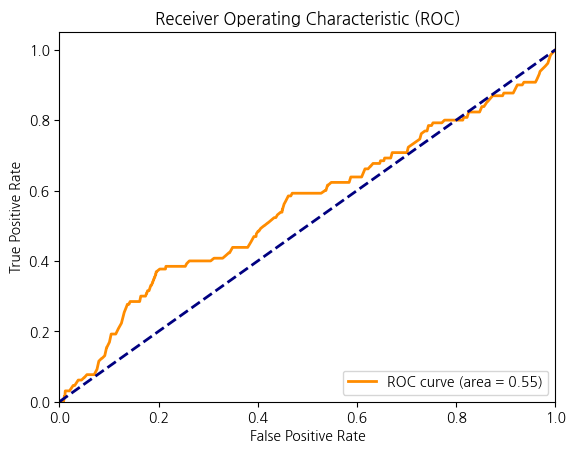

[[    0 95123]
 [    0   130]]


In [150]:
# catboost !!!!!!!!!!!!!

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from catboost import CatBoostClassifier
import numpy as np

# 데이터 준비
X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=15)

oof_preds = np.zeros(X.shape[0])

# 교차 검증을 통한 모델 학습 및 예측
for train_idx, valid_idx in tqdm(skf.split(X, y), total=n_splits):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = CatBoostClassifier(learning_rate=0.1, iterations=1000, eval_metric='F1', verbose=0, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    
    oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]

# 최적의 임계값 찾기
best_threshold = 0
best_f1_score = 0

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    oof_predict = oof_preds > threshold
    f1 = f1_score(y, oof_predict)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

# 최적의 임계값을 사용하여 예측
oof_predict = oof_preds > best_threshold
print(classification_report(y, oof_predict))

# ROC 곡선 그리기
fpr, tpr, _ = roc_curve(y, oof_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# 혼동 행렬 출력
print(confusion_matrix(y, oof_predict))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:03<00:00, 62.82it/s]


Best Threshold: 0.002
Best F1 Score: 0.0055
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     95123
           1       0.00      0.18      0.01       130

    accuracy                           0.91     95253
   macro avg       0.50      0.55      0.48     95253
weighted avg       1.00      0.91      0.95     95253



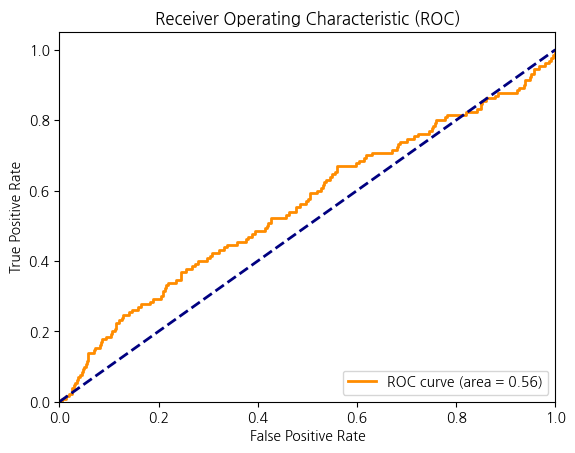

[[86976  8147]
 [  107    23]]


In [151]:
# SVC!!!!!!!!!!!!!!!!!!!!!!!
from sklearn.svm import SVC

# 데이터 준비
X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=15)

oof_preds = np.zeros(X.shape[0])

# 교차 검증을 통한 모델 학습 및 예측
for train_idx, valid_idx in tqdm(skf.split(X, y), total=n_splits):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=15)
    model.fit(X_train, y_train)
    
    oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]

# 최적의 임계값 찾기
best_threshold = 0
best_f1_score = 0

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    oof_predict = oof_preds > threshold
    f1 = f1_score(y, oof_predict)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

# 최적의 임계값을 사용하여 예측
oof_predict = oof_preds > best_threshold
print(classification_report(y, oof_predict))

# ROC 곡선 그리기
fpr, tpr, _ = roc_curve(y, oof_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# 혼동 행렬 출력
print(confusion_matrix(y, oof_predict))

       Feature  Importance
6            시    0.053027
5            일    0.051961
12  상향파워2_lag4    0.043833
27  하향SNR_lag4    0.040302
2         하향파워    0.039229
26  하향SNR_lag3    0.038947
0        상향파워2    0.038490
1        상향SNR    0.037352
8           요일    0.037264
7            분    0.037221
28  하향SNR_lag5    0.036937
24  하향SNR_lag1    0.036066
4     cum_rate    0.035614
20   하향파워_lag2    0.035171
11  상향파워2_lag3    0.034814
18  상향SNR_lag5    0.033650
3        하향SNR    0.033493
19   하향파워_lag1    0.032414
10  상향파워2_lag2    0.032193
21   하향파워_lag3    0.030411
9   상향파워2_lag1    0.029413
25  하향SNR_lag2    0.028581
17  상향SNR_lag4    0.028090
22   하향파워_lag4    0.027688
13  상향파워2_lag5    0.026689
14  상향SNR_lag1    0.025908
23   하향파워_lag5    0.025548
15  상향SNR_lag2    0.025191
16  상향SNR_lag3    0.024504


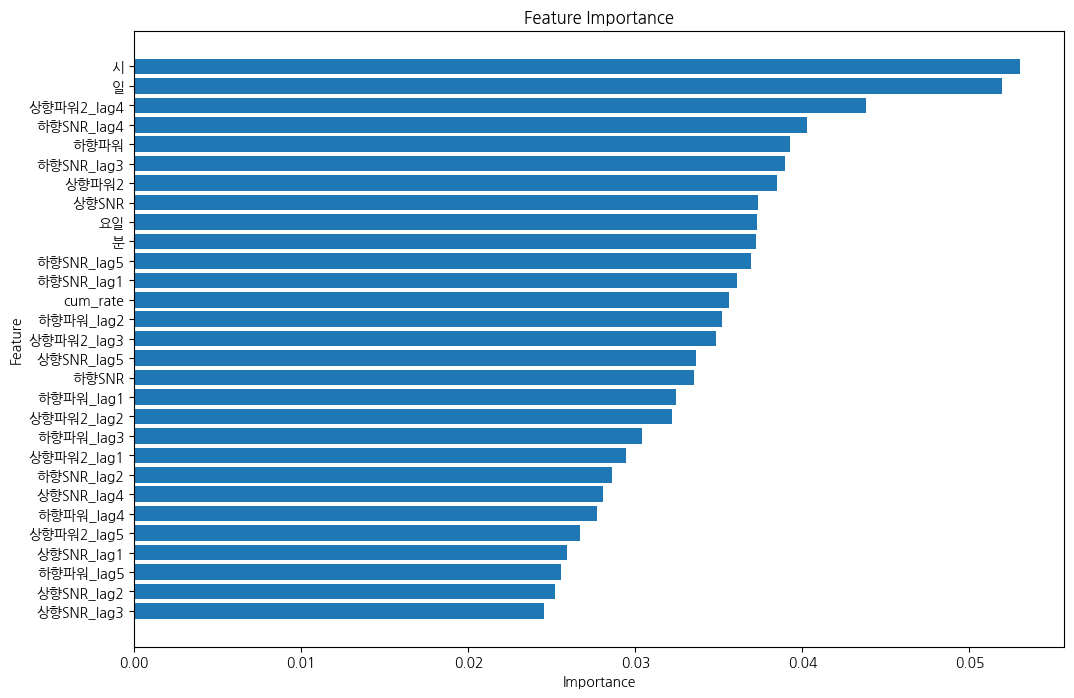

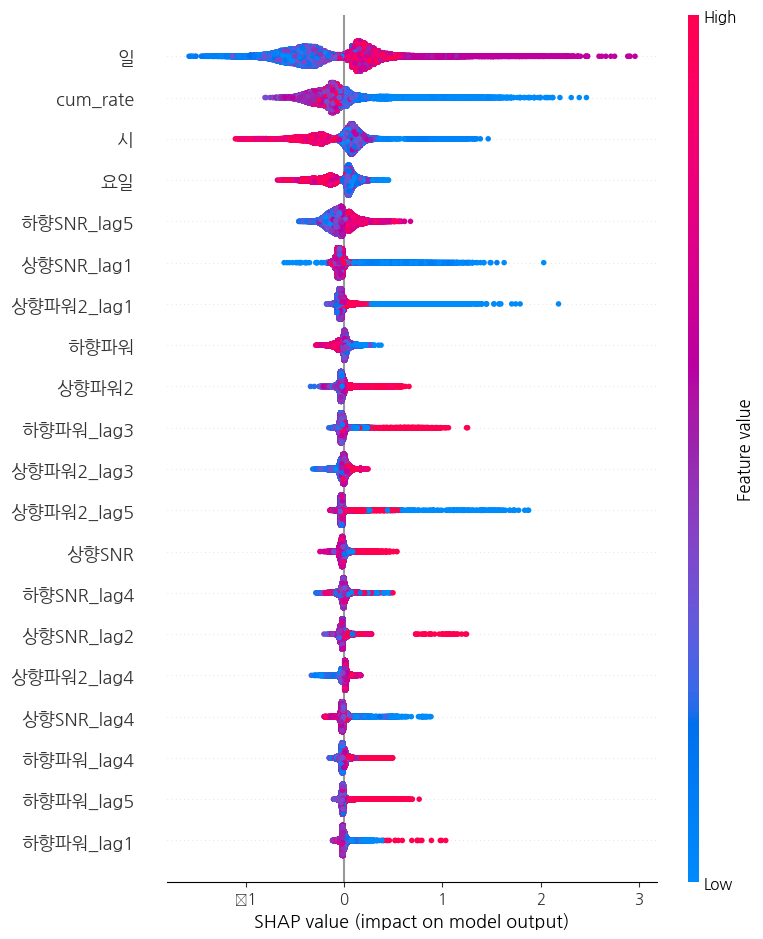

In [154]:
import shap

feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [155]:
# 고장확률과 실제 장애여부 열을 추가하여 비교

X['고장확률'] = oof_preds
X['실제장애여부'] = y
X.sort_values('고장확률', ascending=False)[:50]

,상향파워2,상향SNR,하향파워,하향SNR,cum_rate,일,시,분,요일,상향파워2_lag1,...,하향파워_lag3,하향파워_lag4,하향파워_lag5,하향SNR_lag1,하향SNR_lag2,하향SNR_lag3,하향SNR_lag4,하향SNR_lag5,고장확률,실제장애여부
58312,45.000000,31.000000,-2.000000,38.000000,0.000000,18,1,25,3,45.000000,...,-2.0,-2.0,-1.0,37.000000,37.000000,37.0,37.0,38.0,0.664844,0
58119,43.000000,36.000000,-4.000000,34.000000,0.057221,18,0,15,3,49.000000,...,-4.0,-4.0,-4.0,34.000000,34.000000,34.0,34.0,34.0,0.536341,0
58407,43.000000,36.000000,3.000000,40.000000,0.062069,18,2,5,3,51.000000,...,10.0,10.0,5.5,40.000000,40.000000,39.0,40.0,39.5,0.397287,0
58544,30.000000,36.000000,16.000000,37.000000,0.036036,18,2,55,3,30.571429,...,15.0,15.0,15.0,38.714286,37.000000,37.0,37.0,37.0,0.303579,0
58425,37.500000,28.750000,5.500000,43.000000,0.079268,18,2,5,3,36.000000,...,3.0,2.0,2.0,34.000000,37.000000,36.0,37.0,37.0,0.251433,0
58501,42.800000,35.600000,-5.800000,30.800000,0.309748,18,2,35,3,44.000000,...,-5.0,-4.0,-5.0,39.000000,38.000000,38.0,38.0,38.0,0.240069,0
58476,37.833333,28.666667,-0.333333,40.333333,0.048780,18,2,25,3,44.833333,...,1.0,1.0,1.0,40.333333,38.000000,41.0,40.0,41.0,0.239166,0
58506,48.000000,36.000000,2.000000,36.000000,0.010274,18,2,35,3,51.000000,...,3.0,2.0,2.0,35.000000,35.000000,35.0,35.0,35.0,0.238566,0
58499,28.000000,36.000000,0.000000,26.000000,0.014706,18,2,35,3,28.000000,...,11.0,11.0,11.0,40.000000,39.000000,39.0,39.0,39.0,0.214520,0
58531,28.000000,36.000000,11.000000,39.000000,0.014493,18,2,55,3,27.000000,...,11.0,11.0,11.0,27.000000,26.000000,40.0,39.0,39.0,0.208832,0
